
# **LAP 3 : FEATURE SELECTION !!**

---



## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

[LOAD DATA INTO DATAFRAME](#1)<br>
[1. PKG RFE](#2)<br>
[2. UNIVARIATE FEATURE SELECTION](#3)<br>
[3. PKG VARIANCETHRESHOLD](#4)<br>
[4. DECISIONTREE MODEL](#5)<br>
[5. ADABOOSTCLASSIFIER](#6)<br>
[DICTIONARY OF SELECTED FEATURES](#7)<br>

</div>
<hr>



**So some of the questions we want to know here are .......**

1. Are all the 43 features equally important?
2. Which features are more important?
3. Will the features fetch a better model eval score?


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###      IMPORT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import seaborn as sns
import pickle as pkl
sns.set_style('whitegrid')
get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn import metrics
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

pd.set_option('display.max_columns', 200)
pd.set_option('max_colwidth', 30)
pd.set_option('display.max_rows', 100)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (8,5) # (12,8)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

##            LOAD DATA INTO  DATAFRAME       <a id="1"></a>

In [ ]:
path = '/content/drive/MyDrive/LAP/'

Xt = pd.read_csv(path + 'Xtrn.csv', index_col=False)
Yt = pd.read_csv(path + 'Ytrn.csv', index_col=False)
Xv = pd.read_csv(path + 'Xval.csv', index_col=False)
Yv = pd.read_csv(path + 'Yval.csv', index_col=False)
Xm = pd.read_csv(path + 'Xmm.csv', index_col=False)
Yi = pd.read_csv(path + 'Yin.csv', index_col=False)

###               CHECK  DF  INTEGRITY

In [ ]:
lstc = [Xt,Yt,Xv,Yv,Xm,Yi]
for i in lstc: print(i.shape," ", type(i)); i.index; i.head(2); i.tail(2)

(367812, 43)   <class 'pandas.core.frame.DataFrame'>


RangeIndex(start=0, stop=367812, step=1)

,loan_amnt,term,int_rate,grade,issue_d,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,monthly_inc,EMI,tot_bal,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w
0,-0.229203,1.612785,1.362588,1.743227,0.891014,1.220382,-0.358395,-0.766066,0.790200,-0.330564,0.021966,0.855631,0.541485,-0.09611,-0.061688,-0.812075,-0.716246,-0.784859,-0.001418,1.049376,-0.008854,-0.015467,-0.320697,-0.869447,-0.69943,-0.736398,1.458107,-0.10504,1.847288,-1.224085,-0.022466,-0.234284,-0.06402,-0.141479,-0.09759,-0.079166,-0.22726,-0.026379,-0.109093,-0.073548,-0.062272,-1.240716,1.240716
1,0.794387,1.612785,-0.461455,-0.589153,0.819845,0.929985,-0.358395,-0.766066,0.321438,-0.330564,1.336221,0.213880,-0.147537,-0.09611,-0.061688,0.501230,0.070543,0.513436,-0.001418,1.049376,-0.008854,-0.015467,-0.320697,-0.869447,-0.69943,-0.736398,1.458107,-0.10504,-0.541334,0.816937,-0.022466,-0.234284,-0.06402,-0.141479,-0.09759,-0.079166,-0.22726,-0.026379,-0.109093,-0.073548,-0.062272,0.805986,-0.805986


,loan_amnt,term,int_rate,grade,issue_d,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,monthly_inc,EMI,tot_bal,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w
367810,-1.347835,-0.620045,1.239918,0.965767,-0.626650,-0.499023,-0.358395,-0.766066,-0.444019,-0.330564,-0.815069,1.334017,-1.354886,-0.09611,-0.061688,-1.428468,-1.362552,-1.373782,-0.001418,-0.952947,-0.008854,-0.015467,-0.320697,1.150156,-0.699430,-0.736398,1.458107,-0.10504,-0.541334,0.816937,-0.022466,-0.234284,-0.06402,-0.141479,-0.09759,-0.079166,-0.22726,-0.026379,-0.109093,-0.073548,-0.062272,0.805986,-0.805986
367811,-1.397581,-0.620045,-0.153145,0.188307,0.866936,0.754121,-0.358395,-0.711716,1.078020,1.586462,-0.264392,0.972684,0.942692,-0.09611,-0.061688,-0.416902,-1.426262,-0.324398,-0.001418,-0.952947,-0.008854,-0.015467,-0.320697,1.150156,1.429735,-0.736398,-0.685821,-0.10504,-0.541334,0.816937,-0.022466,-0.234284,-0.06402,-0.141479,-0.09759,-0.079166,-0.22726,-0.026379,-0.109093,-0.073548,-0.062272,0.805986,-0.805986


(367812, 1)   <class 'pandas.core.frame.DataFrame'>


RangeIndex(start=0, stop=367812, step=1)

,default_ind
0,0
1,0


,default_ind
367810,1
367811,1


(99514, 43)   <class 'pandas.core.frame.DataFrame'>


RangeIndex(start=0, stop=99514, step=1)

,loan_amnt,term,int_rate,grade,issue_d,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,monthly_inc,EMI,tot_bal,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w
0,-0.740999,-0.620045,0.443551,0.188307,-0.440526,-1.805732,0.893763,-0.766066,-1.084846,-0.330564,-0.766587,-0.245120,-0.639695,-0.09611,-0.061688,0.185261,-0.585124,0.235464,-0.001418,1.049376,-0.008854,-0.015467,-0.320697,-0.869447,-0.69943,-0.736398,1.458107,-0.10504,-0.541334,-1.224085,-0.022466,-0.234284,-0.06402,-0.141479,-0.09759,-0.079166,-0.22726,-0.026379,-0.109093,13.596608,-0.062272,0.805986,-0.805986
1,-0.011690,-0.620045,0.513706,0.965767,0.679804,1.082038,2.145921,0.664194,-0.616085,-0.330564,-0.959993,1.276381,-0.541263,-0.09611,-0.061688,-0.867968,0.349250,-0.921141,-0.001418,-0.952947,-0.008854,-0.015467,-0.320697,1.150156,-0.69943,1.357961,-0.685821,-0.10504,-0.541334,0.816937,-0.022466,-0.234284,-0.06402,-0.141479,-0.09759,-0.079166,-0.22726,-0.026379,-0.109093,-0.073548,-0.062272,-1.240716,1.240716


,loan_amnt,term,int_rate,grade,issue_d,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,monthly_inc,EMI,tot_bal,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w
99512,-0.61305,-0.620045,0.060034,-0.589153,-0.158147,1.988128,-0.358395,2.094454,1.493342,-0.330564,1.347038,-0.189870,2.411685,-0.09611,-0.061688,0.082327,-0.421193,0.117073,-0.001418,1.049376,-0.008854,-0.015467,-0.320697,-0.869447,-0.69943,1.357961,-0.685821,-0.105040,1.847288,-1.224085,-0.022466,-0.234284,-0.06402,-0.141479,-0.09759,-0.079166,-0.22726,-0.026379,-0.109093,-0.073548,-0.062272,0.805986,-0.805986
99513,0.53849,1.612785,-0.070923,-0.589153,-1.418518,-0.899642,-0.358395,0.664194,1.024581,-0.330564,-1.408463,-2.297871,0.344621,-0.09611,-0.061688,0.360801,-0.126139,0.382910,-0.001418,1.049376,-0.008854,-0.015467,-0.320697,-0.869447,-0.69943,-0.736398,1.458107,9.520144,-0.541334,-1.224085,-0.022466,-0.234284,-0.06402,-0.141479,-0.09759,-0.079166,-0.22726,-0.026379,-0.109093,-0.073548,-0.062272,0.805986,-0.805986


(99514, 1)   <class 'pandas.core.frame.DataFrame'>


RangeIndex(start=0, stop=99514, step=1)

,default_ind
0,1
1,0


,default_ind
99512,0
99513,0


(497568, 43)   <class 'pandas.core.frame.DataFrame'>


RangeIndex(start=0, stop=497568, step=1)

,loan_amnt,term,int_rate,grade,issue_d,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,monthly_inc,EMI,tot_bal,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w
0,0.130435,0.0,0.270971,0.166667,0.559364,0.691423,0.0,0.5,0.090909,0.0,0.321591,0.657502,0.134615,0.0,0.0,0.135922,0.159011,0.135144,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.055072,0.0,0.540925,0.333333,0.559364,0.218055,0.0,1.0,0.045455,0.0,0.069653,0.773763,0.153846,0.0,0.0,0.059883,0.067141,0.060623,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


,loan_amnt,term,int_rate,grade,issue_d,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,monthly_inc,EMI,tot_bal,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w
497566,0.333333,1.0,0.745806,0.666667,0.957597,0.679920,0.025641,1.0,0.727273,0.000000,0.194491,0.240377,0.346154,0.05,0.0,0.397411,0.236748,0.406803,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
497567,0.565217,0.0,0.339095,0.166667,0.957597,0.270818,0.000000,0.5,0.318182,0.015873,0.783854,0.626866,0.153846,0.00,0.0,0.627831,0.689051,0.621390,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


(497568, 1)   <class 'pandas.core.frame.DataFrame'>


RangeIndex(start=0, stop=497568, step=1)

,default_ind
0,0
1,0


,default_ind
497566,0
497567,0


##      DEFINE A DICTIONARY OF SELECTED FEATURES
####      SAVING THE RESULTS FOR DOWNLINE PROCESSING

In [ ]:
colname = Xt.columns.values
print(len(colname))

fsRes = {}
fsRes['DS_Original'] = colname
type(fsRes); fsRes

43


dict

{'DS_Original': array(['loan_amnt', 'term', 'int_rate', 'grade', 'issue_d', 'dti',
        'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
        'revol_bal', 'revol_util', 'total_acc',
        'collections_12_mths_ex_med', 'acc_now_delinq', 'monthly_inc',
        'EMI', 'tot_bal', 'home_ownership_ANY', 'home_ownership_MORTGAGE',
        'home_ownership_NONE', 'home_ownership_OTHER',
        'home_ownership_OWN', 'home_ownership_RENT',
        'verification_status_Not Verified',
        'verification_status_Source Verified',
        'verification_status_Verified', 'purpose_car',
        'purpose_credit_card', 'purpose_debt_consolidation',
        'purpose_educational', 'purpose_home_improvement', 'purpose_house',
        'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
        'purpose_other', 'purpose_renewable_energy',
        'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
        'initial_list_status_f', 'initial_list_status_w'], dtype=object

##  1 : FEATURE SELECTION USING PKG RFE        <a id="2"></a>

#### Recursive Feature Elimination

###               TRAIN THE MODEL

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
classifier=(LogisticRegression(solver='lbfgs',max_iter=500))
rfe = RFE(classifier, step = 26)
model_rfe = rfe.fit(Xt, Yt)
print("Num Features: ",model_rfe.n_features_)
#------------------GET THE LIST OF IMPORTANT FEATURES----------------
result1 = pd.DataFrame({'Ranking': model_rfe.ranking_, 'Support': model_rfe.support_}, index=colname)
result1[(result1.iloc[:,1] == 1.0)].T
#------------------SELECTED FEATURES---------------------------------
res1 = result1[(result1.iloc[:,1] == 1.0)].index.values; res1
fsRes['DS_RFE'] = res1

Num Features:  21


,loan_amnt,int_rate,grade,issue_d,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,monthly_inc,EMI,tot_bal,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,purpose_credit_card,purpose_educational,purpose_small_business,purpose_wedding
Ranking,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Support,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


array(['loan_amnt', 'int_rate', 'grade', 'issue_d', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'monthly_inc', 'EMI', 'tot_bal', 'home_ownership_OWN',
       'home_ownership_RENT', 'verification_status_Not Verified',
       'purpose_credit_card', 'purpose_educational',
       'purpose_small_business', 'purpose_wedding'], dtype=object)

Since it is elimination, highest rank is removed first and so on.... Rank 1 indicates selected features.

###               PREDICT ON VALIDATION DATA

In [ ]:
Y_pred=model_rfe.predict(Xv)
#----------EVALUATE THE RFE MODEL-----------------------
print("Confusion Matrix (RFE): \n",confusion_matrix(Yv, Y_pred))
print("\n Classification report: \n",classification_report(Yv,Y_pred))
print("Accuracy of the model: ",accuracy_score(Yv, Y_pred))

Confusion Matrix (RFE): 
 [[62549 29344]
 [ 2500  5121]]

 Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.68      0.80     91893
           1       0.15      0.67      0.24      7621

    accuracy                           0.68     99514
   macro avg       0.56      0.68      0.52     99514
weighted avg       0.90      0.68      0.75     99514

Accuracy of the model:  0.6800048234419278


###               PLOT OF IMPORTANT FEATURES

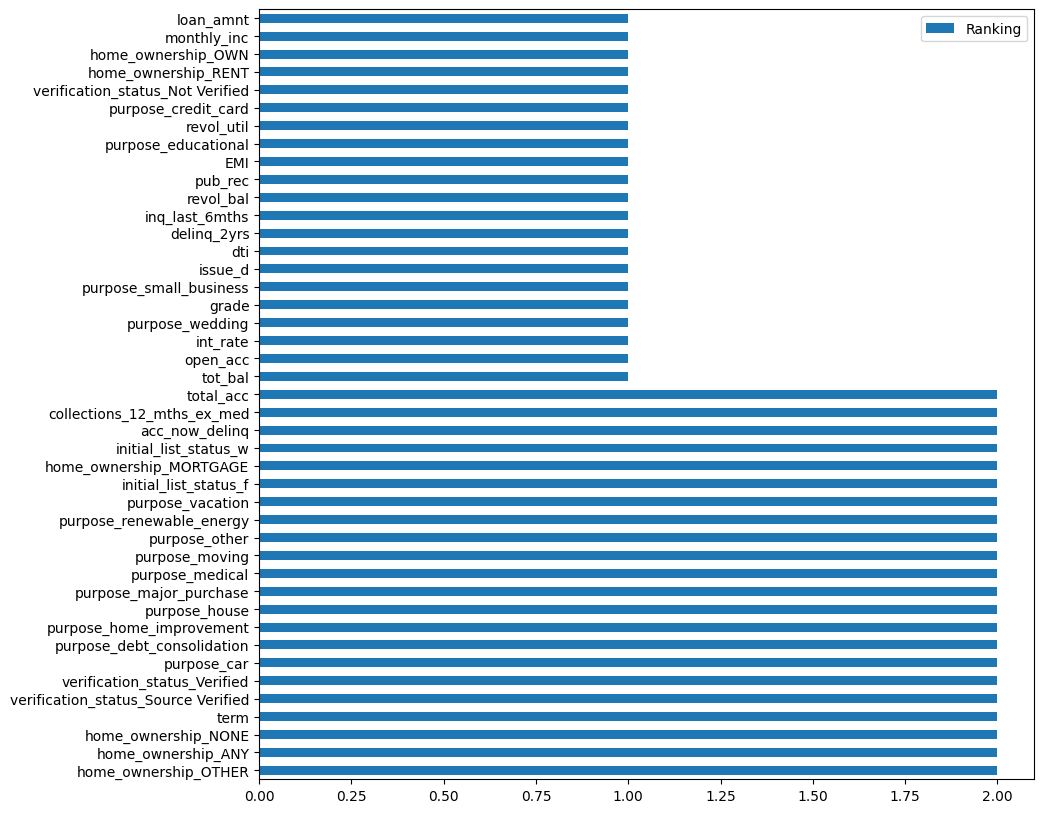

In [ ]:
result1.sort_values(by='Ranking', ascending=False).plot(kind='barh', figsize=(10,10));

We can go ahead and choose all features with Ranking=1

##  2 : FEATURE SELECTION USING UNIVARIATE FEATURE SELECTION       <a id="3"></a>
The chi squared (chi^2) statistical test for non-negative features, is used to select k of the best features.

###               STANDARDIZE IV FEATURES WITH PKG MINMAXSCALER

This was done in the previous steps while spliting cleaned dataset into X and Y.

###               TRAIN MODEL USING PKG SELECTKBEST & PKG CHI2

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

test = SelectKBest(score_func=chi2, k=16)          # ................Specifying K values here !!!
fit1 = test.fit(Xm, Yi)
#-----------GET THE LIST OF IMPORTANT FEATURES-------------
result2 = pd.DataFrame({'Scores': fit1.scores_, 'Support': fit1.get_support(), 'P-values': test.pvalues_}, index=colname)
result21 = result2.sort_values(by='Scores', ascending=False); result21.T
#-----------SELECTED BEST FEATURES-------------------------
res2 = result21[(result21.iloc[:,1] == 1.0)].index.values; res2
fsRes['DS_UFS'] = res2

,initial_list_status_w,grade,int_rate,verification_status_Verified,initial_list_status_f,inq_last_6mths,purpose_small_business,term,purpose_credit_card,home_ownership_RENT,home_ownership_MORTGAGE,issue_d,verification_status_Source Verified,verification_status_Not Verified,purpose_other,tot_bal,monthly_inc,revol_util,purpose_moving,dti,purpose_medical,purpose_home_improvement,purpose_wedding,total_acc,purpose_debt_consolidation,purpose_house,home_ownership_OTHER,purpose_educational,purpose_renewable_energy,EMI,home_ownership_OWN,revol_bal,open_acc,pub_rec,loan_amnt,purpose_car,purpose_vacation,home_ownership_NONE,collections_12_mths_ex_med,acc_now_delinq,delinq_2yrs,purpose_major_purchase,home_ownership_ANY
Scores,1520.721744,1513.672658,1484.395416,1035.083692,987.88152,803.626506,758.699559,758.221614,459.05067,424.457836,340.046516,314.266642,248.61152,238.260075,190.160731,175.497298,161.998224,96.927787,54.716726,42.33734,39.945625,39.188756,32.971033,23.627739,23.32951,23.117146,20.029258,18.158155,17.566541,12.363926,8.32984,8.028371,5.308236,4.571602,4.387255,3.623255,3.399991,3.353585,2.125007,1.61201,1.598063,1.309615,0.082361
Support,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
P-values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.000001,0.000002,0.000008,0.00002,0.000028,0.000438,0.0039,0.004605,0.021225,0.032506,0.036209,0.056977,0.065197,0.067059,0.144912,0.204209,0.206178,0.252464,0.774123


array(['initial_list_status_w', 'grade', 'int_rate',
       'verification_status_Verified', 'initial_list_status_f',
       'inq_last_6mths', 'purpose_small_business', 'term',
       'purpose_credit_card', 'home_ownership_RENT',
       'home_ownership_MORTGAGE', 'issue_d',
       'verification_status_Source Verified',
       'verification_status_Not Verified', 'purpose_other', 'tot_bal'],
      dtype=object)

###               PLOT OF IMPORTANT FEATURES

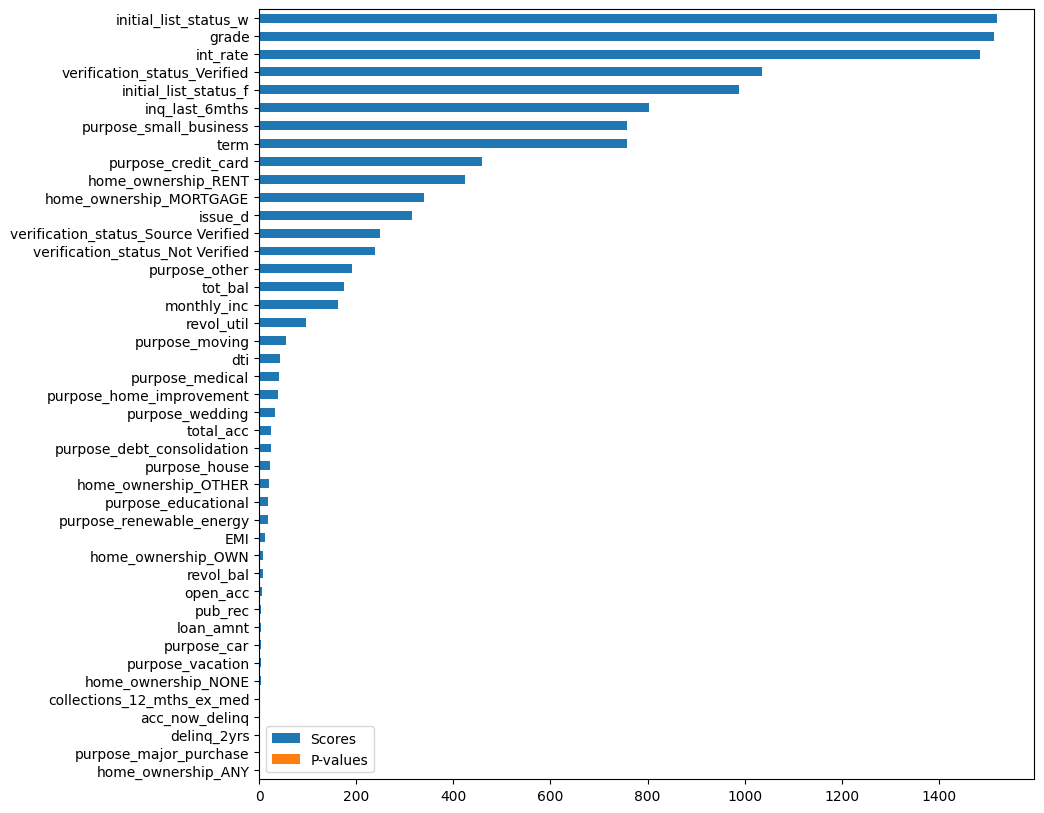

In [ ]:
result2.sort_values(by='Scores').plot(kind='barh',figsize=(10,10), stacked=True);

 Here we shall choose all features with has support as True

##  3 : FEATURE SELECTION USING PKG VARIANCETHRESHOLD <a id="4"></a>

###               FIT DATA & GET FIT.VARIANCES

In [ ]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(0.3)             #......... ADJUST THRESHOLD (scaling required)

fit2 = vt.fit(Xt, Yt)
fit2.variances_[0:4]
len(fit2.variances_)
#-------------GET THE LIST OF IMPORTANT FEATURES-----------
result3 = pd.DataFrame({'Variances': fit2.variances_, 'Support': fit2.get_support()}, index=colname)
result3.sort_values(by='Variances', ascending=False).T
#-------------SELECTED BEST FEATURES-----------------------
res3 = result3[(result3.iloc[:,1] == 1.0)].index.values; res3

array([0.97606844, 1.05757214, 1.0158831 , 1.04115224])

43

,home_ownership_OTHER,purpose_educational,purpose_small_business,home_ownership_NONE,purpose_renewable_energy,purpose_house,purpose_moving,purpose_wedding,purpose_medical,purpose_other,term,verification_status_Verified,grade,purpose_vacation,issue_d,inq_last_6mths,int_rate,home_ownership_RENT,purpose_debt_consolidation,purpose_major_purchase,home_ownership_MORTGAGE,loan_amnt,home_ownership_OWN,verification_status_Not Verified,verification_status_Source Verified,purpose_car,initial_list_status_f,initial_list_status_w,purpose_home_improvement,total_acc,dti,purpose_credit_card,revol_util,EMI,open_acc,revol_bal,monthly_inc,tot_bal,delinq_2yrs,acc_now_delinq,pub_rec,collections_12_mths_ex_med,home_ownership_ANY
Variances,1.852587,1.594829,1.568115,1.521551,1.453972,1.239593,1.19027,1.189314,1.165892,1.134163,1.057572,1.05538,1.041152,1.036235,1.032369,1.019743,1.015883,1.010694,0.990828,0.987399,0.986951,0.976068,0.966564,0.966154,0.96516,0.965045,0.932818,0.932818,0.930485,0.926653,0.920267,0.919998,0.919379,0.916657,0.910527,0.905009,0.891573,0.887348,0.876339,0.863149,0.81368,0.790948,0.0
Support,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False


array(['loan_amnt', 'term', 'int_rate', 'grade', 'issue_d', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'monthly_inc',
       'EMI', 'tot_bal', 'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'verification_status_Not Verified',
       'verification_status_Source Verified',
       'verification_status_Verified', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy',
       'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
       'initial_list_status_f', 'initial_list_status_w'], dtype=object)

###               PLOT OF IMPORTANT FEATURES

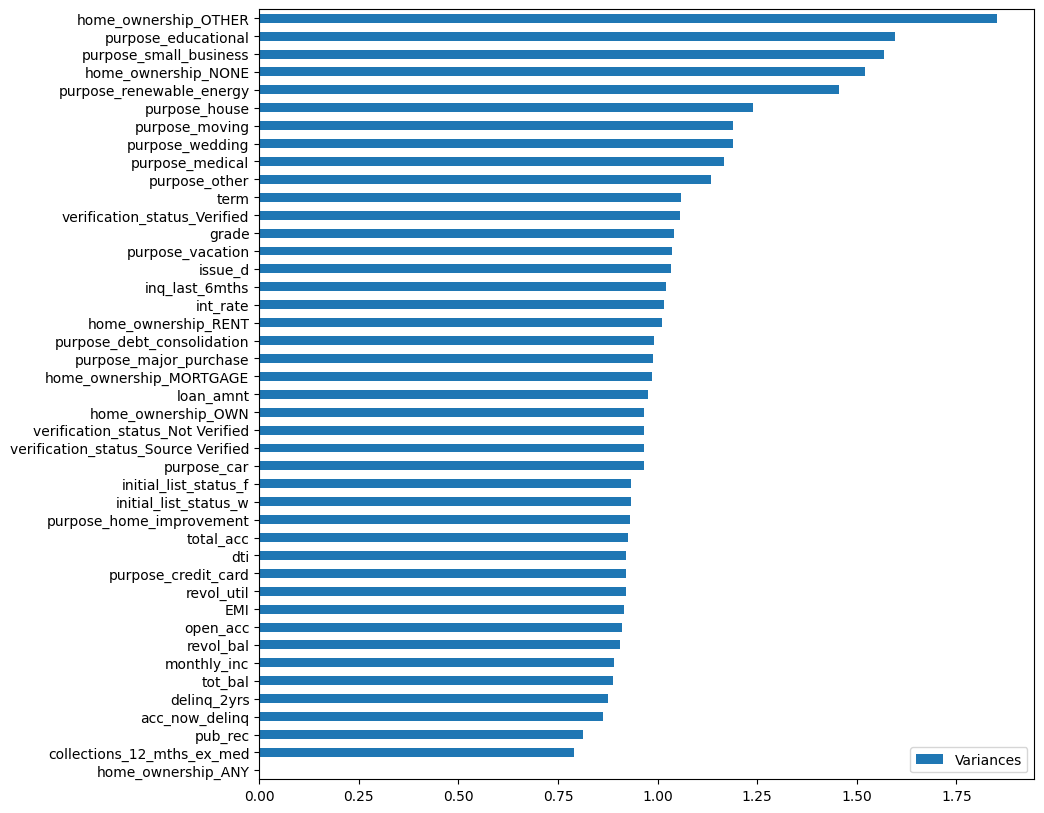

In [ ]:
result3.sort_values(by='Variances').plot(kind='barh',figsize=(10,10));

In [ ]:
# Leaving out the last three, choosing the rest of the features.
res3 = res3[0:40]
fsRes['DS_VT'] = res3

##  4 : FEATURE SELECTION USING DECISIONTREE MODEL   <a id="5"></a>

###               TRAIN THE MODEL

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model_DecisionTree = DecisionTreeClassifier(criterion='gini', random_state=10)
model_DecisionTree.fit(Xt,Yt)
#-------------GET THE LIST OF IMPORTANT FEATURES-----------
result4 = pd.DataFrame({'Importance': model_DecisionTree.feature_importances_}, index=colname)
result4.sort_values(by='Importance', ascending=False).T
#-------------SELECTED Best FEATURES--------------------
res4 = result4.sort_values(by='Importance', ascending=False).index.values; res4

DecisionTreeClassifier(random_state=10)

,issue_d,grade,int_rate,dti,revol_bal,revol_util,monthly_inc,tot_bal,total_acc,open_acc,EMI,loan_amnt,inq_last_6mths,delinq_2yrs,home_ownership_RENT,pub_rec,term,purpose_debt_consolidation,purpose_credit_card,verification_status_Source Verified,verification_status_Verified,verification_status_Not Verified,home_ownership_MORTGAGE,purpose_other,initial_list_status_f,initial_list_status_w,home_ownership_OWN,purpose_home_improvement,purpose_small_business,purpose_major_purchase,purpose_medical,purpose_car,purpose_wedding,collections_12_mths_ex_med,purpose_moving,purpose_vacation,purpose_house,acc_now_delinq,purpose_renewable_energy,home_ownership_OTHER,purpose_educational,home_ownership_NONE,home_ownership_ANY
Importance,0.280061,0.219998,0.166939,0.038128,0.036267,0.035904,0.032427,0.027167,0.026915,0.026302,0.021342,0.020203,0.011,0.00848,0.00414,0.004077,0.003986,0.003549,0.00328,0.003182,0.00295,0.002932,0.002915,0.002354,0.002345,0.002156,0.002127,0.001798,0.001584,0.000989,0.000822,0.000808,0.000571,0.000567,0.000497,0.000434,0.000402,0.000166,0.000141,0.00005,0.000036,0.000009,0.0


array(['issue_d', 'grade', 'int_rate', 'dti', 'revol_bal', 'revol_util',
       'monthly_inc', 'tot_bal', 'total_acc', 'open_acc', 'EMI',
       'loan_amnt', 'inq_last_6mths', 'delinq_2yrs',
       'home_ownership_RENT', 'pub_rec', 'term',
       'purpose_debt_consolidation', 'purpose_credit_card',
       'verification_status_Source Verified',
       'verification_status_Verified', 'verification_status_Not Verified',
       'home_ownership_MORTGAGE', 'purpose_other',
       'initial_list_status_f', 'initial_list_status_w',
       'home_ownership_OWN', 'purpose_home_improvement',
       'purpose_small_business', 'purpose_major_purchase',
       'purpose_medical', 'purpose_car', 'purpose_wedding',
       'collections_12_mths_ex_med', 'purpose_moving', 'purpose_vacation',
       'purpose_house', 'acc_now_delinq', 'purpose_renewable_energy',
       'home_ownership_OTHER', 'purpose_educational',
       'home_ownership_NONE', 'home_ownership_ANY'], dtype=object)

In [ ]:
Y_pred4=model_DecisionTree.predict(Xv)
#----------EVALUATE THE DT MODEL-----------------------
print("Confusion Matrix (DT): \n",confusion_matrix(Yv, Y_pred4))
print("\n Classification report: \n",classification_report(Yv,Y_pred4))
print("Accuracy of the model: ",accuracy_score(Yv, Y_pred4))

Confusion Matrix (DT): 
 [[78122 13771]
 [ 5583  2038]]

 Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.85      0.89     91893
           1       0.13      0.27      0.17      7621

    accuracy                           0.81     99514
   macro avg       0.53      0.56      0.53     99514
weighted avg       0.87      0.81      0.83     99514

Accuracy of the model:  0.8055148019374159


###               PLOT OF IMPORTANT FEATURES

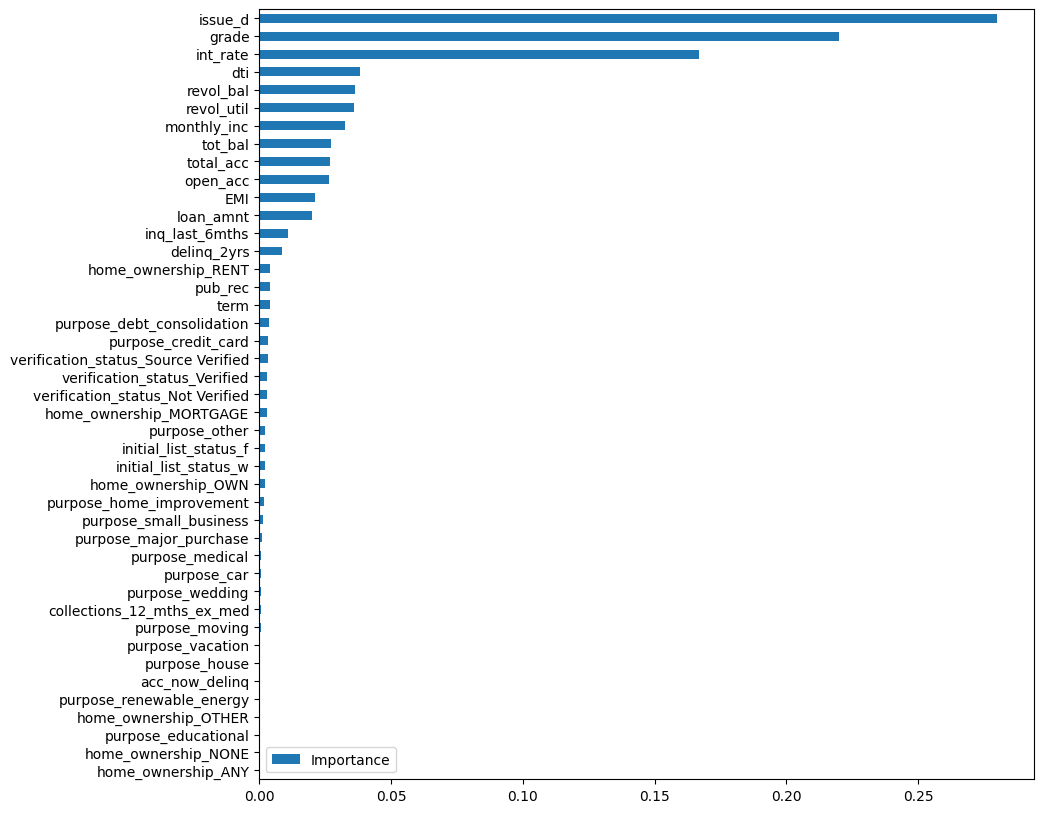

In [ ]:
result4.sort_values(by='Importance').plot(kind='barh',figsize=(10,10));

In [ ]:
# Choosing the elbow as cutoff (say 0.01), we shall choose all the features above it
res4 = res4[0:13]
fsRes['DS_DT'] = res4

##  5 :  FEATURE SELECTION USING ADABOOSTCLASSIFIER    <a id="6"></a>

###               TRAIN THE MODEL

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=50, random_state=42)    # originally 500 estimators
ada.fit(Xt, Yt)
#-------------GET THE LIST OF IMPORTANT FEATURES-----------
result5 = pd.DataFrame({'Importance': ada.feature_importances_}, index=colname)
result5.sort_values(by='Importance', ascending=False).T
#-------------SELECTED Best FEATURES----------------------
res5 = result5.sort_values(by='Importance', ascending=False).index.values; res5

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4),
                   random_state=42)

,open_acc,grade,issue_d,inq_last_6mths,delinq_2yrs,int_rate,monthly_inc,loan_amnt,pub_rec,EMI,home_ownership_RENT,dti,purpose_debt_consolidation,total_acc,revol_bal,tot_bal,term,verification_status_Source Verified,revol_util,acc_now_delinq,initial_list_status_w,purpose_medical,purpose_moving,purpose_car,purpose_credit_card,home_ownership_NONE,purpose_major_purchase,initial_list_status_f,purpose_wedding,purpose_vacation,purpose_small_business,purpose_renewable_energy,purpose_other,purpose_house,home_ownership_OWN,purpose_home_improvement,purpose_educational,collections_12_mths_ex_med,verification_status_Verified,home_ownership_ANY,verification_status_Not Verified,home_ownership_MORTGAGE,home_ownership_OTHER
Importance,0.465301,0.160391,0.14067,0.114908,0.062563,0.019389,0.011959,0.008153,0.006344,0.005445,0.00149,0.001425,0.000774,0.000348,0.000322,0.000318,0.000056,0.00005,0.000037,0.00003,0.000029,1.453284e-13,5.858369e-14,8.254017e-15,2.348765e-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array(['open_acc', 'grade', 'issue_d', 'inq_last_6mths', 'delinq_2yrs',
       'int_rate', 'monthly_inc', 'loan_amnt', 'pub_rec', 'EMI',
       'home_ownership_RENT', 'dti', 'purpose_debt_consolidation',
       'total_acc', 'revol_bal', 'tot_bal', 'term',
       'verification_status_Source Verified', 'revol_util',
       'acc_now_delinq', 'initial_list_status_w', 'purpose_medical',
       'purpose_moving', 'purpose_car', 'purpose_credit_card',
       'home_ownership_NONE', 'purpose_major_purchase',
       'initial_list_status_f', 'purpose_wedding', 'purpose_vacation',
       'purpose_small_business', 'purpose_renewable_energy',
       'purpose_other', 'purpose_house', 'home_ownership_OWN',
       'purpose_home_improvement', 'purpose_educational',
       'collections_12_mths_ex_med', 'verification_status_Verified',
       'home_ownership_ANY', 'verification_status_Not Verified',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER'], dtype=object)

In [ ]:
Y_pred5=ada.predict(Xv)
#-------------EVALUATE THE ADA MODEL---------------------
print("Confusion Matrix (ADA): \n",confusion_matrix(Yv, Y_pred5))
print("\n Classification report: \n",classification_report(Yv,Y_pred5))
print("Accuracy of the model: ",accuracy_score(Yv, Y_pred5))

Confusion Matrix (ADA): 
 [[82208  9685]
 [ 5353  2268]]

 Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.89      0.92     91893
           1       0.19      0.30      0.23      7621

    accuracy                           0.85     99514
   macro avg       0.56      0.60      0.57     99514
weighted avg       0.88      0.85      0.86     99514

Accuracy of the model:  0.8488855839379383


###               PLOT OF IMPORTANT FEATURES

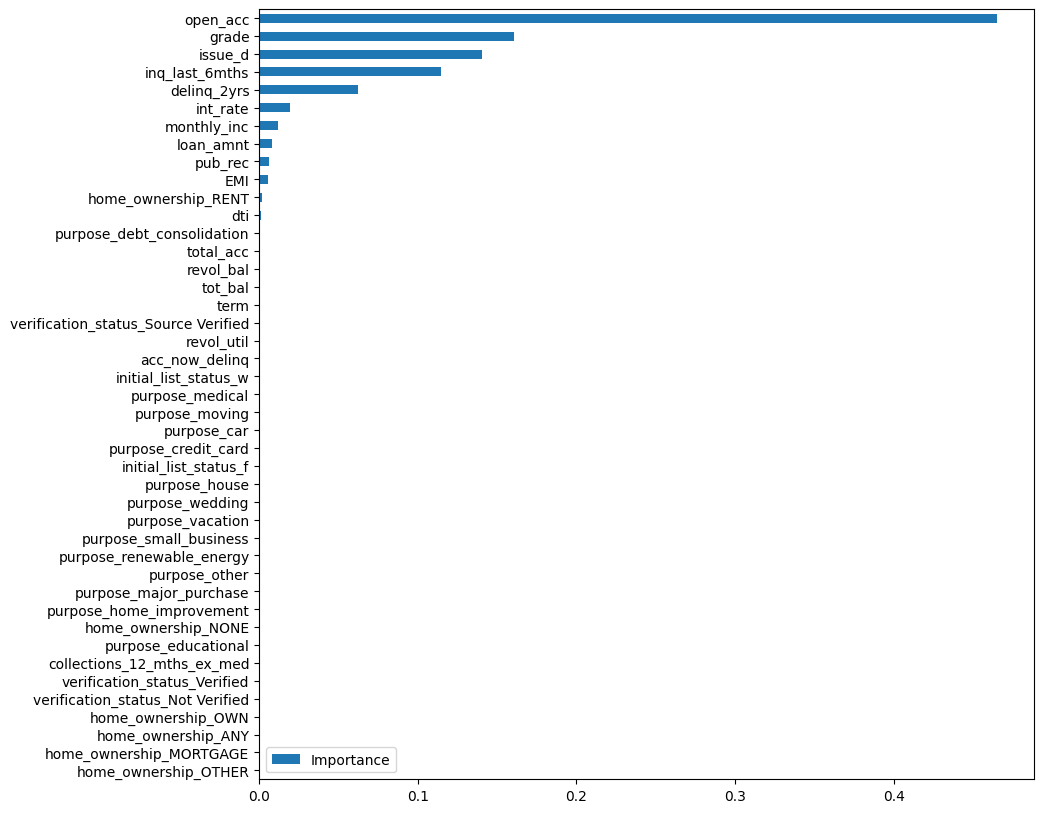

In [ ]:
result5.sort_values(by='Importance').plot(kind='barh',figsize=(10,10));

In [ ]:
# Choosing the elbow as cutoff (say 0.01), we shall choose all the features above it
res5 = res5[0:14]
fsRes['DS_Ada'] = res5

##      DICTIONARY OF SELECTED FEATURES      <a id="7"></a>

In [ ]:
# For Downline processing
fsRes

{'DS_Original': array(['loan_amnt', 'term', 'int_rate', 'grade', 'issue_d', 'dti',
        'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
        'revol_bal', 'revol_util', 'total_acc',
        'collections_12_mths_ex_med', 'acc_now_delinq', 'monthly_inc',
        'EMI', 'tot_bal', 'home_ownership_ANY', 'home_ownership_MORTGAGE',
        'home_ownership_NONE', 'home_ownership_OTHER',
        'home_ownership_OWN', 'home_ownership_RENT',
        'verification_status_Not Verified',
        'verification_status_Source Verified',
        'verification_status_Verified', 'purpose_car',
        'purpose_credit_card', 'purpose_debt_consolidation',
        'purpose_educational', 'purpose_home_improvement', 'purpose_house',
        'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
        'purpose_other', 'purpose_renewable_energy',
        'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
        'initial_list_status_f', 'initial_list_status_w'], dtype=object

#### Save to Pickle on disk

In [ ]:
# np.save("DataSet/fsArray", fsRes)

with open(path + 'fsDict', "wb") as fp:   #Pickling
   pkl.dump(fsRes, fp)

#### Ckeck saved file data

In [ ]:
# a =  np.load("DataSet/fsArray.npy", allow_pickle=True)

with open(path + 'fsDict', "rb") as fp:   # Unpickling
   a = pkl.load(fp)

In [ ]:
# for i in (0,1,2,3,4): print("Length of Set", i+1, "= ", len(a[i]), " and ", len(fsRes[i]))
for x, y in a.items(): print("Length of Data Set", x, "= ", len(y), " and ", len(fsRes[x]))

Length of Data Set DS_Original =  43  and  43
Length of Data Set DS_RFE =  21  and  21
Length of Data Set DS_UFS =  16  and  16
Length of Data Set DS_VT =  40  and  40
Length of Data Set DS_DT =  13  and  13
Length of Data Set DS_Ada =  14  and  14
